### Set paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wfdb
import wfdb
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from scipy.stats import median_abs_deviation

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix

from sklearn.neural_network import MLPClassifier

### Importing AFDB

In [ ]:
records = []
properties = []
annot = []
AnnSymb = []
AnnSamp = []
AnnRhythm = []
Rpeak_Samp = []
Rpeak_Symb = []


# Choose the local path were the Physionet data is stored
for f in glob.glob('/content/drive/MyDrive/Applied machine learning/Bachelor_work/data/atrial_fibrillation_data/*.dat'): ##### change the path to own directory.       
                                        

    sig, fields = wfdb.rdsamp(f[:-4], channels=[1])  #### In this function, pass 
                                                     #### "channels=[0]" or "channels=[1]" to select channel 1 or 2.
    ann = wfdb.rdann(f[:-4], 'atr')
    QRS = wfdb.rdann(f[:-4], 'qrs')
    Symb = pd.Series(ann.symbol)
    Samp = pd.Series(ann.sample)
    QRS_Symb = pd.Series(QRS.symbol)
    QRS_Samp = pd.Series(QRS.sample)
    Rhythm = pd.Series(ann.aux_note)
    records.append(sig)
    properties.append(fields)
    annot.append(ann)
    AnnSymb.append(Symb)
    AnnSamp.append(Samp)
    Rpeak_Symb.append(QRS_Symb)
    Rpeak_Samp.append(QRS_Samp)
    AnnRhythm.append(Rhythm)
    
AnnSymb = pd.Series(AnnSymb).values
AnnSamp = pd.Series(AnnSamp).values

### Plotting the signal

In [ ]:
sig[1]

array([-0.45])

In [ ]:
annot[0]

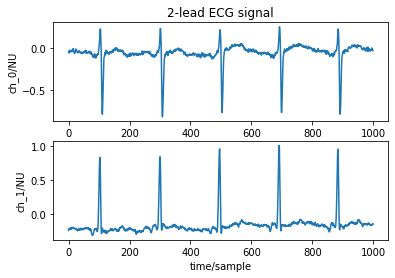

(array([[-0.04 , -0.235],
        [-0.055, -0.21 ],
        [-0.06 , -0.21 ],
        ...,
        [-0.02 , -0.14 ],
        [-0.02 , -0.15 ],
        [-0.03 , -0.14 ]]),
 {'fs': 250,
  'sig_len': 1000,
  'n_sig': 2,
  'base_date': None,
  'base_time': datetime.time(11, 0),
  'units': ['mV', 'mV'],
  'sig_name': ['ECG1', 'ECG2'],
  'comments': []})

In [ ]:
# wfdb.plotrec(records[0], annotation = properties[0],
#    title = 'Record 100 from MIT-BIH Arrhythmia Database',
#    timeunits = 'seconds', figsize = (10, 4), ecggrids = 'all')
signals, fields = wfdb.rdsamp(r"/content/drive/MyDrive/Applied machine learning/Bachelor_work/data/atrial_fibrillation_data/04126", sampto=1000)

wfdb.plot_items(signal=signals, fs=fields['fs'], title='2-lead ECG signal')
# Display it with the additional information
display((signals, fields))

### Preprocessing AFDB dataset

In [ ]:
labeled_Rpeaks = []
appended_data = []
k=1
for i in range(23): ## 23 records
    for j in range(len(AnnSamp[i])-1): ## AnnSamp or AnnRhythm -- both same dimensions
        df = pd.DataFrame(Rpeak_Samp[i][(Rpeak_Samp[i] > AnnSamp[i][j]) & (Rpeak_Samp[i] < AnnSamp[i][j+1])])
        df['Label'] = AnnRhythm[i][j]
        df['ids'] = k
        appended_data.append(df)
    k+=1    

labeled_Rpeaks = pd.concat(appended_data)

labeled_Rpeaks_N_AFIB_AFL = labeled_Rpeaks.loc[(labeled_Rpeaks.Label == '(N') | (labeled_Rpeaks.Label == '(AFIB') | (labeled_Rpeaks.Label == '(AFL'), :]
labeled_Rpeaks_N_AFIB_AFL['Label'] = labeled_Rpeaks_N_AFIB_AFL['Label'].map({'(N':0 ,'(AFIB':1, '(AFL':2})
labeled_Rpeaks_N_AFIB_AFL['Label'] = labeled_Rpeaks_N_AFIB_AFL['Label'].astype(int)
labeled_Rpeaks_N_AFIB_AFL.rename(columns={0: 'Rpeaks'},inplace=True, errors='raise')

In [ ]:
labeled_Rpeaks_N_AFIB_AFL

,Rpeaks,Label,ids
0,61,0,1
1,200,0,1
2,358,0,1
3,584,0,1
4,729,0,1
...,...,...,...
15373,2849597,0,23
15374,2849785,0,23
15375,2849975,0,23
15376,2850083,0,23


### Inter-patient approach on AFDB using LOGO-CV

In [ ]:
values_to_keep = [0, 1, 2] ### 713954 (total) - 708567 (NOT AFL) = 5387 AFL labels;   = 253862 AFIB labels;   = 454705 N labels
bool_result = labeled_Rpeaks_N_AFIB_AFL['Label'].isin(values_to_keep)
wrong_rythms = [i for i in bool_result if i is False]
len(wrong_rythms)

0

In [ ]:
logo = LeaveOneGroupOut()
ids = labeled_Rpeaks_N_AFIB_AFL.loc[:, 'ids']
logo.get_n_splits(groups=ids)

21

### Functions

#### Segmenting function

In [ ]:
def segmenting_record(seg_value, data):
    rri2 = np.diff(data) ### Storing the intervals between rpeaks
    rri2 = np.array(rri2, dtype=np.float64) ### Ensuring no overflow issues happens, when calculating in for loop later

    amount = -(len(rri2) % seg_value) # amount of data points to remove, for equal length segments with no residue points
    # print(f"segmenting_record: Amount to remove {amount-1}")
    
    if amount == 0:
        rec_amount = rri2
    else:
        rec_amount = rri2[:amount]
    seg_shape = len(rec_amount) // seg_value # amount of total segments (given the specified segment length) 
    # print(f"segmenting_record: Shape 0: {seg_shape}")
    
    segmented_rec = rec_amount.reshape(seg_shape,seg_value) 
    return segmented_rec, amount-1, seg_shape

#### Feature calculations

In [ ]:
def feature_calc(segmented_record_tr):
    %run "/content/drive/MyDrive/Applied machine learning/Master_work/features_utils.ipynb"
    all_features_tr = []### Calculating all_features for every single segmented "block" inside the segmented_record variable

    for x in range(len(segmented_record_tr)):

        #MEAN
        ff1_tr = np.nanmean(segmented_record_tr[x]) ### nanmean, nanstd computes values while ignoring nan-values
        #STD
        ff2_tr = np.nanstd(segmented_record_tr[x])
        #RMSSD
        sum_tr = 0
        for y in range(len(segmented_record_tr[x]) - 1): ### loops 19 times for segment=20
            sum_tr += (segmented_record_tr[x][y] - segmented_record_tr[x][y+1])**2
        sum_multiplied_tr = 1/(len(segmented_record_tr) - 1) * sum_tr
        ff3_tr = np.sqrt(sum_multiplied_tr)
        #NORMALIZED RMSSD
        ff4_tr = (ff3_tr / ff1_tr)
        #SHANNON ENTROPY
        ff5_tr = entropy(segmented_record_tr[x])
        #MEAN ABSOLUTE DEVIATION
        ff6_tr = mean_abs_deviation(segmented_record_tr[x])
        #MEDIAN ABSOLUTE DEVIATION
        ff7_tr = median_abs_deviation(segmented_record_tr[x])

        my_all_features_tr = pd.Series([np.around(ff1_tr,3), np.around(ff2_tr,3), np.around(ff3_tr,3), np.around(ff4_tr,3),
                                        np.around(ff5_tr,3), np.around(ff6_tr,3), np.around(ff7_tr,3)],
                                index=['Mean','STD','RMSSD','Normalized RMSSD','Shannon Entropy',
                                        'Mean absolute deviation','Median absolute deiviation'])
        all_features_tr.append(my_all_features_tr)
    
    
    return all_features_tr

#### Labeling segments function

In [ ]:
def labeling_y(amount_tr, seg_shape_tr, seg_len, data):

    y_amount_tr = data[:amount_tr] 
    y_shape_tr = y_amount_tr.reshape(seg_shape_tr, seg_len) 

    y_list_tr = []

    ### Calc if every 20 segment block is normal synus rythm or afib or afl
    for l in range(len(y_shape_tr)):

        n_count = np.count_nonzero(y_shape_tr[l] == 0)
        afib_count = np.count_nonzero(y_shape_tr[l] == 1)
        afl_count = np.count_nonzero(y_shape_tr[l] == 2)

        all_counts = {'n':n_count, 'afib':afib_count, 'afl':afl_count} 

        all_counts_single_max = max(all_counts, key=all_counts.get) ### If single highest value, get its key
        all_counts_highest = max(all_counts.values()) ### Check if their are multiple highest counts, if true, than later set block equal to normal rythm
        all_counts_multiple_max = [k for k, v in all_counts.items() if v == all_counts_highest] 
        if(all_counts_single_max == 'n'):
          y_list_tr.append(0) ### set to normal rythm
        elif(all_counts_single_max == 'afib'):
          y_list_tr.append(1) ### set to afib rythm
        elif(all_counts_single_max == 'afl'):
          y_list_tr.append(2) ### set to afl rythm
        elif(len(all_counts_multiple_max) > 1):
          y_list_tr.append(0) ### set to normal rythm, because of multiple highest counts

    y_list_tr = np.array(y_list_tr, dtype=np.float64)
    # print(f"len(y_list_tr): {len(y_list_tr)}, y_list_tr.dtype: {y_list_tr.dtype}")
    
    
    return y_list_tr

### Initiliazing variables & Models

In [ ]:
##### Chosen params after hyperparameters tuning using GridsearchCV 
pipeline_svm = Pipeline([('scalar1', StandardScaler()),
                          ('svm_classifier', SVC(gamma="scale", C=20, kernel='rbf', probability=True))])

pipeline_dt = Pipeline([('scalar2', StandardScaler()),
                        ('dt_classifier', tree.DecisionTreeClassifier(criterion='entropy', max_depth=12))])

pipeline_rf = Pipeline([('scalar 4', StandardScaler()),
                          ('rf_classifier', RandomForestClassifier(n_estimators=200))])
xgb_model = XGBClassifier(use_label_encoder=False)

adaBoost_clf = AdaBoostClassifier() 

estimators = [('svm',pipeline_svm), ('dt',pipeline_dt), ('rf',pipeline_rf)]#, ('adaboost', adaBoost_clf), ('xgboost', xgb_model)]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), stack_method='predict')

nn_clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1) ## output 3 (for the 3 classes) - solver: softmax (search for mlp) (last layer softmax) ## Use Keras instead of sklearn for nn ### Later cnn etc.

In [ ]:
labeled_Rpeaks_N_AFIB_AFL.reset_index(drop=True, inplace=True)

Rpeaks_N_AFIB = labeled_Rpeaks_N_AFIB_AFL["Rpeaks"]
Label_N_AFIB = labeled_Rpeaks_N_AFIB_AFL["Label"]
Label_N_AFIB = np.array(Label_N_AFIB, dtype=np.float64)

seg_len = 20
record_val = 0
y_pred_svm_all_ts = []
y_pred_dt_all_ts = []
y_pred_rf_all_ts = []
y_pred_stacking_all_ts = []
y_pred_xgboost_all_ts = []
y_pred_adaboost_all_ts = []
y_score_svm_all_ts = []
y_score_dt_all_ts = []
y_score_rf_all_ts = []
y_score_stacking_all_ts = []
y_score_xgboost_all_ts = []
y_score_adaboost_all_ts = []
y_prob_svm_all_ts = []
y_prob_dt_all_ts = []
y_prob_rf_all_ts = []
y_prob_stacking_all_ts = []
y_prob_xgboost_all_ts = []
y_prob_adaboost_all_ts = []

y_pred_svm_all_tr = []
y_pred_dt_all_tr = []
y_pred_rf_all_tr = []
y_pred_stacking_all_tr = []
y_pred_xgboost_all_tr = []
y_pred_adaboost_all_tr = []
y_score_svm_all_tr = []
y_score_dt_all_tr = []
y_score_rf_all_tr = []
y_score_stacking_all_tr = []
y_score_xgboost_all_tr = []
y_score_adaboost_all_tr = []
y_prob_svm_all_tr = []
y_prob_dt_all_tr = []
y_prob_rf_all_tr = []
y_prob_stacking_all_tr = []
y_prob_xgboost_all_tr = []
y_prob_adaboost_all_tr = []

y_train_all = []
y_test_all = []

y_tr_all = []
y_ts_all = []

In [ ]:
from sklearn.metrics import accuracy_score

acc_avg_svm = []
acc_avg_rf = []
acc_avg_nn = []

for train_index, test_index in logo.split(Rpeaks_N_AFIB, Label_N_AFIB, ids):
    print('################################ {} ################################'.format(record_val))
    print('train_index: {}'.format(train_index))
    print('test_index: {} \n'.format(test_index))
    
    X_train, X_test = Rpeaks_N_AFIB[train_index], Rpeaks_N_AFIB[test_index]
    y_train, y_test = Label_N_AFIB[train_index], Label_N_AFIB[test_index]

    y_train_all.append(y_train)
    y_test_all.append(y_test)

    print('X_train.shape: {}'.format(X_train.shape))
    print('X_train: \n{}\n'.format(X_train))
    print('y_test.shape: {}\n'.format(y_test.shape))

    ############################################ Train AFDB #########################################################

    
    ######### Function calls ###########
    #### GENERATING TRAIN DATA
    segmented_record_tr, amount_tr, seg_shape_tr = segmenting_record(seg_len, X_train)
    all_features_tr = feature_calc(segmented_record_tr)
    y_list_tr = labeling_y(amount_tr, seg_shape_tr, seg_len, y_train)
    #### GENERATING TEST DATA
    segmented_record_ts, amount_ts, seg_shape_ts = segmenting_record(seg_len, X_test)
    all_features_ts = feature_calc(segmented_record_ts)
    y_list_ts = labeling_y(amount_ts, seg_shape_ts, seg_len, y_test)

    print('segmented_record_tr.shape: {}'.format(segmented_record_tr.shape))
    print('segmented_record_tr: \n{}'.format(segmented_record_tr))


    y_tr = np.asarray(y_list_tr)
    X_tr = np.asarray(all_features_tr)
    print(f"shape of y_train: {np.shape(y_tr)}, type of y_train: {type(y_tr)}")
    print(f"shape of X_train: {np.shape(X_tr)}, type of X_train: {type(X_tr)}")
    y_ts = np.asarray(y_list_ts)
    X_ts = np.asarray(all_features_ts)
    print(f"shape of y_test: {np.shape(y_ts)}, type of y_test: {type(y_ts)}")
    print(f"shape of X_test: {np.shape(X_ts)}, type of X_test: {type(X_ts)}\n")

    ### FITTING
    pipeline_svm.fit(X_tr, y_tr)
    pipeline_rf.fit(X_tr, y_tr)
    nn_clf.fit(X_tr, y_tr)
    # pipeline_rf.fit(X_tr, y_tr)
    # clf.fit(X_tr, y_tr)
    # xgb_model.fit(X_tr, y_tr)
    # adaBoost_clf.fit(X_tr, y_tr)

    ### PREDICTING
    y_pred_svm_ts = pipeline_svm.predict(X_ts)
    y_pred_rf_ts = pipeline_rf.predict(X_ts)
    y_pred_nn_ts = nn_clf.predict(X_ts)
    # y_pred_rf_ts = pipeline_rf.predict(X_ts)
    # y_pred_stacking_ts = clf.predict(X_ts)
    # y_pred_xgboost_ts = xgb_model.predict(X_ts)
    # y_pred_adaboost_ts = adaBoost_clf.predict(X_ts)

    ### ACCURACY SCORES
    acc_svm = accuracy_score(y_ts, y_pred_svm_ts)
    acc_rf = accuracy_score(y_ts, y_pred_rf_ts)
    acc_nn = accuracy_score(y_ts, y_pred_nn_ts)


    print("acc_svm: {}".format(acc_svm))
    print("acc_rf: {}".format(acc_rf))
    print("acc_nn: {}".format(acc_nn))
    
    acc_avg_svm.append(acc_svm)
    acc_avg_rf.append(acc_rf)
    acc_avg_nn.append(acc_nn)

    record_val += 1

##### AVERAGE ACCURACY SCORES

print("average of acc_svm: {}".format(np.mean(np.array(acc_avg_svm))))
print("std of acc_svm: {}".format(np.std(np.array(acc_avg_svm))))

print("average of acc_rf: {}".format(np.mean(np.array(acc_avg_rf))))
print("std of acc_rf: {}".format(np.std(np.array(acc_avg_rf))))

print("average of acc_nn: {}".format(np.mean(np.array(acc_avg_nn))))
print("std of acc_nn: {}".format(np.std(np.array(acc_avg_nn))))

################################ 0 ################################
train_index: [  8233   8234   8235 ... 713951 713952 713953]
test_index: [   0    1    2 ... 8230 8231 8232] 

X_train.shape: (705721,)
X_train: 
8233          136
8234          276
8235          416
8236          557
8237          696
           ...   
713949    2849597
713950    2849785
713951    2849975
713952    2850083
713953    2850266
Name: Rpeaks, Length: 705721, dtype: int64

y_test.shape: (8233,)

segmented_record_tr.shape: (35286, 20)
segmented_record_tr: 
[[140. 140. 141. ... 139. 138. 142.]
 [141. 137. 141. ... 138. 138. 142.]
 [140. 137. 143. ... 138. 144. 138.]
 ...
 [188. 187. 188. ... 188. 187. 186.]
 [188. 189. 188. ... 190. 192. 184.]
 [187. 186. 188. ... 190. 108. 183.]]
shape of y_train: (35286,), type of y_train: <class 'numpy.ndarray'>
shape of X_train: (35286, 7), type of X_train: <class 'numpy.ndarray'>
shape of y_test: (411,), type of y_test: <class 'numpy.ndarray'>
shape of X_test: (411, 7), 

#### Test block (below)

In [ ]:
# fake_y_shape_tr = [2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1] ### 20 len block
# fake_y_shape_tr.append(0)
# print(fake_y_shape_tr)
# # len(fake_y_shape_tr)
# n_l = fake_y_shape_tr.count(0)
# afib_l = fake_y_shape_tr.count(1)
# afl_l = fake_y_shape_tr.count(2)

# n_l = np.count_nonzero(fake_y_shape_tr == 0)
# afib_l = np.count_nonzero(fake_y_shape_tr == 1)
# afl_l = np.count_nonzero(fake_y_shape_tr == 2)

# together_l = {'n':n_l, 'afib':afib_l, 'afl':afl_l}
# print(together_l)

# together_l_max = max(together_l, key=together_l.get)
# print(together_l_max)
# bool_max = together_l_max == 'afib'
# print(bool_max)

# # max(together_l, key=together_l.get)

# highest = max(together_l.values())
# print(highest)

# z = [k for k, v in together_l.items() if v == highest]
# len(z)

#### Pipelines & fitting the models

In [ ]:
# y_tr_all.append(y_tr) ## Used for what?

# pipeline_svm.fit(X_tr, y_tr)
# pipeline_dt.fit(X_tr, y_tr)
# pipeline_rf.fit(X_tr, y_tr)
# clf.fit(X_tr, y_tr)
# xgb_model.fit(X_tr, y_tr)
# adaBoost_clf.fit(X_tr, y_tr)

# y_pred_svm_tr = pipeline_svm.predict(X_tr)
# y_pred_dt_tr = pipeline_dt.predict(X_tr)
# y_pred_rf_tr = pipeline_rf.predict(X_tr)
# y_pred_stacking_tr = clf.predict(X_tr)
# y_pred_xgboost_tr = xgb_model.predict(X_tr)
# y_pred_adaboost_tr = adaBoost_clf.predict(X_tr)

# y_prob_svm_tr = pipeline_svm.predict_proba(X_tr)
# y_prob_dt_tr = pipeline_dt.predict_proba(X_tr)
# y_prob_rf_tr = pipeline_rf.predict_proba(X_tr)
# y_prob_stacking_tr = clf.predict_proba(X_tr)
# y_prob_xgboost_tr = xgb_model.predict_proba(X_tr)
# y_prob_adaboost_tr = adaBoost_clf.predict_proba(X_tr)

# y_pred_svm_all_tr.append(y_pred_svm_tr)
# y_pred_dt_all_tr.append(y_pred_dt_tr)
# y_pred_rf_all_tr.append(y_pred_rf_tr)
# y_pred_stacking_all_tr.append(y_pred_stacking_tr)
# y_pred_xgboost_all_tr.append(y_pred_xgboost_tr)
# y_pred_adaboost_all_tr.append(y_pred_adaboost_tr)

# y_prob_svm_all_tr.append(y_pred_svm_tr)
# y_prob_dt_all_tr.append(y_pred_dt_tr)
# y_prob_rf_all_tr.append(y_pred_rf_tr)
# y_prob_stacking_all_tr.append(y_pred_stacking_tr)
# y_prob_xgboost_all_tr.append(y_pred_xgboost_tr)
# y_prob_adaboost_all_tr.append(y_pred_adaboost_tr)

shape of y: (34928,), type of y: <class 'numpy.ndarray'>
shape of X: (34928, 7), type of X: <class 'numpy.ndarray'>


### Averaging the performance metrics

In [ ]:
from sklearn.metrics import accuracy_score
acc_avg = []
for i in range(len(y_ts_all)):
    acc_all = accuracy_score(y_ts_all[i], y_pred_adaboost_all_ts[i])
    acc_avg.append(acc_all)
print(np.mean(np.array(acc_avg)))
print(np.std(np.array(acc_avg)))

In [ ]:
from sklearn.metrics import f1_score
f1_avg = []
for i in range(len(y_ts_all)):
    f1_all = f1_score(y_ts_all[i], y_pred_adaboost_all_ts[i], average='weighted')
    f1_avg.append(f1_all)
print(np.mean(np.array(f1_avg)))
print(np.std(np.array(f1_avg)))

In [ ]:
from sklearn.metrics import confusion_matrix
fpr_all = []
for i in range(len(y_ts_all)):
    cm_all = confusion_matrix(y_ts_all[i], y_pred_adaboost_all_ts[i])
    fpr_cm = cm_all[0][1]/(cm_all[0][1]+cm_all[0][0])
    fpr_all.append(fpr_cm)
print(np.mean(np.array(fpr_all)))
print(np.std(np.array(fpr_all)))

In [ ]:
from sklearn.metrics import precision_score
prec_avg = []
for i in range(len(y_ts_all)):
    prec_all = precision_score(y_ts_all[i], y_pred_adaboost_all_ts[i], average='weighted')
    prec_avg.append(prec_all)
print(np.mean(np.array(prec_avg)))
print(np.std(np.array(prec_avg)))

In [ ]:
spec_all = []
for i in range(len(y_ts_all)):
    cm_all = confusion_matrix(y_ts_all[i], y_pred_adaboost_all_ts[i])
    spec_cm = cm_all[0][0]/(cm_all[0][1]+cm_all[0][0])*100
    spec_all.append(spec_cm)
print(np.mean(np.array(spec_all)))
print(np.std(np.array(spec_all)))

In [ ]:
from sklearn.metrics import recall_score
sens_avg = []
for i in range(len(y_ts_all)):
    sens_all = recall_score(y_ts_all[i], y_pred_adaboost_all_ts[i], average='weighted')
    sens_avg.append(sens_all)
print(np.mean(np.array(sens_avg)))
print(np.std(np.array(sens_avg)))

#### X_test and y_test

In [ ]:
###################### Test AFDB ###################################

segmented_record_ts, amount_ts, seg_shape_ts = segmenting_record(seg_len, X_test)

print('test')
print(segmented_record_ts.shape)
print(segmented_record_ts)

%run "/content/drive/MyDrive/Applied machine learning/Master_work/features_utils.ipynb"

all_features_ts = []

### Calculating all_features for every single segmented "block" inside the segmented_record variable
for x in range(len(segmented_record_ts)):

    #MEAN
    ff1_ts = np.nanmean(segmented_record_ts[x]) ### nanmean, nanstd computes values while ignoring nan-values
    #STD
    ff2_ts = np.nanstd(segmented_record_ts[x])
    #RMSSD
    sum_ts = 0
    for y in range(len(segmented_record_ts[x]) - 1): ### loops 19 times for segment=20
        sum_ts += (segmented_record_ts[x][y] - segmented_record_ts[x][y+1])**2
    sum_multiplied_ts = 1/(len(segmented_record_ts) - 1) * sum_ts
    ff3_ts = np.sqrt(sum_multiplied_ts)
    #NORMALIZED RMSSD
    ff4_ts = (ff3_ts / ff1_ts)
    #SHANNON ENTROPY
    ff5_ts = entropy(segmented_record_ts[x])
    #MEAN ABSOLUTE DEVIATION
    ff6_ts = mean_abs_deviation(segmented_record_ts[x])
    #MEDIAN ABSOLUTE DEVIATION
    ff7_ts = median_abs_deviation(segmented_record_ts[x])

    my_all_features_ts = pd.Series([np.around(ff1_ts, 3), np.around(ff2_ts, 3), np.around(ff3_ts,3), np.around(ff4_ts,  3),
                                    np.around(ff5_ts, 3), np.around(ff6_ts, 3), np.around(ff7_ts, 3)],
                            index=['Mean','STD','RMSSD','Normalized RMSSD','Shannon Entropy',
                                    'Mean absolute deviation','Median absolute deiviation'])
    all_features_ts.append(my_all_features_ts)


y_amount_ts = y_test[:amount_ts] 
y_shape_ts = y_amount_ts.reshape(seg_shape_ts, seg_len) 

y_list_ts = []

### Calc if every 20 segment block is Normal synus rythm or AFIB
for l in range(len(y_shape_ts)):
    n_count = np.count_nonzero(y_shape_ts[l] == 0)
    afib_count = np.count_nonzero(y_shape_ts[l] == 1)
    afl_count = np.count_nonzero(y_shape_ts[l] == 2)

    all_counts = {'n':n_count, 'afib':afib_count, 'afl':afl_count} 

    all_counts_single_max = max(all_counts, key=all_counts.get) ### If single highest value, get its key
    all_counts_highest = max(all_counts.values()) ### Check if their are multiple highest counts, if true, than later set block equal to normal rythm
    all_counts_multiple_max = [k for k, v in all_counts.items() if v == all_counts_highest] 

    if(all_counts_single_max == 'n'):
      y_list_ts.append(0) ### set to normal rythm
    elif(all_counts_single_max == 'afib'):
      y_list_ts.append(1) ### set to afib rythm
    elif(all_counts_single_max == 'afl'):
      y_list_ts.append(2) ### set to afl rythm
    elif(len(all_counts_multiple_max) > 1):
      y_list_ts.append(0) ### set to normal rythm, because of multiple highest counts

y_ts = np.array(y_list_ts, dtype=np.float64)
X_ts = np.asarray(all_features_ts)
print(f"Length: {len(y_ts)}, Type: {y_ts.dtype}")

print(f"shape of y: {np.shape(y_ts)}, type of y: {type(y_ts)}")
print(f"shape of X: {np.shape(X_ts)}, type of X: {type(X_ts)}")

y_ts_all.append(y_ts)

y_pred_svm_ts = pipeline_svm.predict(X_ts)
y_pred_dt_ts = pipeline_dt.predict(X_ts)
y_pred_rf_ts = pipeline_rf.predict(X_ts)
y_pred_stacking_ts = clf.predict(X_ts)
y_pred_xgboost_ts = xgb_model.predict(X_ts)
y_pred_adaboost_ts = adaBoost_clf.predict(X_ts)

y_score_svm_ts = pipeline_svm.predict_proba(X_ts)
y_score_dt_ts = pipeline_dt.predict_proba(X_ts)
y_score_rf_ts = pipeline_rf.predict_proba(X_ts)
y_score_stacking_ts = clf.predict_proba(X_ts)
y_score_xgboost_ts = xgb_model.predict_proba(X_ts)
y_score_adaboost_ts = adaBoost_clf.predict_proba(X_ts)

y_pred_svm_all_ts.append(y_pred_svm_ts)
y_pred_dt_all_ts.append(y_pred_dt_ts)
y_pred_rf_all_ts.append(y_pred_rf_ts)
y_pred_stacking_all_ts.append(y_pred_stacking_ts)
y_pred_xgboost_all_ts.append(y_pred_xgboost_ts)
y_pred_adaboost_all_ts.append(y_pred_adaboost_ts)

y_score_svm_all_ts.append(y_pred_svm_ts)
y_score_dt_all_ts.append(y_pred_dt_ts)
y_score_rf_all_ts.append(y_pred_rf_ts)
y_score_stacking_all_ts.append(y_pred_stacking_ts)
y_score_xgboost_all_ts.append(y_pred_xgboost_ts)
y_score_adaboost_all_ts.append(y_pred_adaboost_ts)

### Below cells is running seperate scripts inside this file. These scripts contains NSRDB, LTAFDB, and MITDB databases.

In [ ]:
%run "/content/drive/MyDrive/Applied machine learning/Master_work/preprocess_mitdb.ipynb"
%run "/content/drive/MyDrive/Applied machine learning/Master_work/preprocess_nsrdb.ipynb"
%run "/content/drive/MyDrive/Applied machine learning/Master_work/preprocess_ltafdb.ipynb"

In [ ]:
y = np.asarray(y_list)
X = np.asarray(all_features)

y_A = np.asarray(y_list_A)
X_A = np.asarray(all_features_A)

y_nsr = np.asarray(y_list_nsr)
X_nsr = np.asarray(all_features_nsr)

y_long = np.asarray(y_list_long)
X_long = np.asarray(all_features_long)

## RESULTS for $N$=20

### Evaluate on unseen test databases (NSRDB, LTAFDB, and MITDB)

In [ ]:
# print("-------------------------------(Testing scores below for Normal sinus Rhythm DB)-----------------------------------------------")
# print(f"SVM: {pipeline_svm.score(X_nsr, y_nsr)}")
# print(f"DT: {pipeline_dt.score(X_nsr, y_nsr)}")
# print(f"RF: {pipeline_rf.score(X_nsr, y_nsr)}")
# print(f"Stacking: {clf.score(X_nsr, y_nsr)}")
# print(f"Xgbost: {xgb_model.score(X_nsr, y_nsr)}")
# print(f"AdaBoost: {adaBoost_clf.score(X_nsr, y_nsr)}")
# print("-------------------------------(Testing scores below for Arrhythmia DB)-----------------------------------------------")
# print(f"SVM: {pipeline_svm.score(X_A, y_A)}")
# print(f"DT: {pipeline_dt.score(X_A, y_A)}")
# print(f"RF: {pipeline_rf.score(X_A, y_A)}")
# print(f"Stacking: {clf.score(X_A, y_A)}")
# print(f"Xgbost: {xgb_model.score(X_A, y_A)}")
# print(f"AdaBoost: {adaBoost_clf.score(X_A, y_A)}")
# print("-------------------------------(Testing scores below for Long term AF DB)---------------------------------------------")
# print(f"SVM: {pipeline_svm.score(X_long, y_long)}")
# print(f"DT: {pipeline_dt.score(X_long, y_long)}")
# print(f"RF: {pipeline_rf.score(X_long, y_long)}")
# print(f"Stacking: {clf.score(X_long, y_long)}")
# print(f"Xgbost: {xgb_model.score(X_long, y_long)}")
# print(f"AdaBoost: {adaBoost_clf.score(X_long, y_long)}")

### Classification reports

In [ ]:
y_pred_svm_A = pipeline_svm.predict(X_A)
y_pred_dt_A = pipeline_dt.predict(X_A)
y_pred_rf_A = pipeline_rf.predict(X_A)
y_pred_stacking_A = clf.predict(X_A)
y_pred_xgboost_A = xgb_model.predict(X_A)
y_pred_adaboost_A = adaBoost_clf.predict(X_A)

y_pred_svm_nsr = pipeline_svm.predict(X_nsr)
y_pred_dt_nsr = pipeline_dt.predict(X_nsr)
y_pred_rf_nsr = pipeline_rf.predict(X_nsr)
y_pred_stacking_nsr = clf.predict(X_nsr)
y_pred_xgboost_nsr = xgb_model.predict(X_nsr)
y_pred_adaboost_nsr = adaBoost_clf.predict(X_nsr)

y_pred_svm_long = pipeline_svm.predict(X_long)
y_pred_dt_long = pipeline_dt.predict(X_long)
y_pred_rf_long = pipeline_rf.predict(X_long)
y_pred_stacking_long = clf.predict(X_long)
y_pred_xgboost_long = xgb_model.predict(X_long)
y_pred_adaboost_long = adaBoost_clf.predict(X_long)

In [ ]:
target_names = ['class 0', 'class 1'] # class 0 = Normal rythm, class 1 = AFIB
print("Arrhythmia DATA BELOW")
print("SVM below:")
print(classification_report(y_A, y_pred_svm_A, target_names=target_names))
print("DT below:")
print(classification_report(y_A, y_pred_dt_A, target_names=target_names))
print("RF below:")
print(classification_report(y_A, y_pred_rf_A, target_names=target_names))
print("Stacking below:")
print(classification_report(y_A, y_pred_stacking_A, target_names=target_names))
print("Xgboost below:")
print(classification_report(y_A, y_pred_xgboost_A, target_names=target_names))
print("Adaboost below:")
print(classification_report(y_A, y_pred_adaboost_A, target_names=target_names))

In [ ]:
target_names = ['class 0', 'class 1'] # class 0 = Normal rythm, class 1 = AFIB
print("NSRDB DATA BELOW")
print("SVM below:")
print(classification_report(y_nsr, y_pred_svm_nsr, target_names=target_names))
print("DT below:")
print(classification_report(y_nsr, y_pred_dt_nsr, target_names=target_names))
print("RF below:")
print(classification_report(y_nsr, y_pred_rf_nsr, target_names=target_names))
print("Stacking below:")
print(classification_report(y_nsr, y_pred_stacking_nsr, target_names=target_names))
print("Xgboost below:")
print(classification_report(y_nsr, y_pred_xgboost_nsr, target_names=target_names))
print("Adaboost below:")
print(classification_report(y_nsr, y_pred_adaboost_nsr, target_names=target_names))

In [ ]:
target_names = ['class 0', 'class 1'] # class 0 = Normal rythm, class 1 = AFIB
print("LONG TERM AF DATA BELOW")
print("SVM below:")
print(classification_report(y_long, y_pred_svm_long, target_names=target_names))
print("DT below:")
print(classification_report(y_long, y_pred_dt_long, target_names=target_names))
print("RF below:")
print(classification_report(y_long, y_pred_rf_long, target_names=target_names))
print("Stacking below:")
print(classification_report(y_long, y_pred_stacking_long, target_names=target_names))
print("Xgboost below:")
print(classification_report(y_long, y_pred_xgboost_long, target_names=target_names))
print("Adaboost below:")
print(classification_report(y_long, y_pred_adaboost_long, target_names=target_names))

### ROC curves for AdaBoost algorithm for $N$=20 (you may plot ROC curve for other classifiers and other segment lengths as well by running this script and change the "seg_len" above to 10 and 60)

In [ ]:
auc_svm_A = metrics.roc_auc_score(y_A, y_score_svm_A)
auc_svm_long = metrics.roc_auc_score(y_long, y_score_svm_long)

fpr_svm_A, tpr_svm_A, thresholds_svm_A = metrics.roc_curve(y_A, y_score_svm_A)
fpr_svm_long, tpr_svm_long, thresholds_svm_long = metrics.roc_curve(y_long, y_score_svm_long)

In [ ]:
# auc_ada = metrics.roc_auc_score(y_test, y_score_adaboost)
auc_ada_A = metrics.roc_auc_score(y_A, y_score_adaboost_A)
auc_ada_long = metrics.roc_auc_score(y_long, y_score_adaboost_long)

# fpr_ada, tpr_ada, thresholds_ada = metrics.roc_curve(y_test, y_score_adaboost)
fpr_ada_A, tpr_ada_A, thresholds_ada_A = metrics.roc_curve(y_A, y_score_adaboost_A)
fpr_ada_long, tpr_ada_long, thresholds_ada_long = metrics.roc_curve(y_long, y_score_adaboost_long)


plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--', linewidth=3) # dashed line with black(k) color

# plt.plot(fpr_ada, tpr_ada, label='AFDB (AUC = %0.4f)' % auc_ada, linewidth=3)
plt.plot(fpr_ada_A, tpr_ada_A, label='MITDB (AUC = %0.4f)' % auc_ada_A, linewidth=3)
plt.plot(fpr_ada_long, tpr_ada_long, label='LTAFDB (AUC = %0.4f)' % auc_ada_long, linewidth=3)

plt.xlabel('False positive rate', fontsize=18)
plt.ylabel('True positive rate', fontsize=18)
plt.ylabel('True positive rate', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('ROC curve (Adaboost)', fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()

### Confusion matrix for AdaBoost algorithm for $N$=20 (you may plot confusion matrix for other classifiers and other segment lengths as well by running this script and change the "seg_len" above to 10 and 60)

In [ ]:
cm_svm_A = confusion_matrix(y_A, y_pred_svm_A)
cm_dt_A = confusion_matrix(y_A, y_pred_dt_A)
cm_rf_A = confusion_matrix(y_A, y_pred_rf_A)
cm_stacking_A = confusion_matrix(y_A, y_pred_stacking_A)
cm_xgboost_A = confusion_matrix(y_A, y_pred_xgboost_A)
cm_adaboost_A = confusion_matrix(y_A, y_pred_adaboost_A)

cm_svm_long = confusion_matrix(y_long, y_pred_svm_long)
cm_dt_long = confusion_matrix(y_long, y_pred_dt_long)
cm_rf_long = confusion_matrix(y_long, y_pred_rf_long)
cm_stacking_long = confusion_matrix(y_long, y_pred_stacking_long)
cm_xgboost_long = confusion_matrix(y_long, y_pred_xgboost_long)
cm_adaboost_long = confusion_matrix(y_long, y_pred_adaboost_long)

cm_svm_nsr = confusion_matrix(y_nsr, y_pred_svm_nsr)
cm_dt_nsr = confusion_matrix(y_nsr, y_pred_dt_nsr)
cm_rf_nsr = confusion_matrix(y_nsr, y_pred_rf_nsr)
cm_stacking_nsr = confusion_matrix(y_nsr, y_pred_stacking_nsr)
cm_xgboost_nsr = confusion_matrix(y_nsr, y_pred_xgboost_nsr)
cm_adaboost_nsr = confusion_matrix(y_nsr, y_pred_adaboost_nsr)

target_names = ['Normal', 'AFIB']

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title, fontsize=14)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 fontsize=14,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.grid(False)
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label',fontsize=14)

#### COnfusion matrix for MITDB 

In [ ]:
plot_confusion_matrix(cm=cm_adaboost_A, normalize=True, classes=['Normal','AFIB'])

#### COnfusion matrix for LTAFDB

In [ ]:
plot_confusion_matrix(cm=cm_adaboost_long, normalize=True, classes=['Normal','AFIB'])

In [ ]:
while True:pass

KeyboardInterrupt: ignored